In [41]:
%matplotlib inline 
%matplotlib nbagg
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops


import data
import utils
import custom_ops

In [42]:
from tensorflow.contrib.layers import fully_connected, batch_norm

reset_default_graph()

# Defining model
num_iterations = 3e4
batch_size=64
number_inputs=42
number_outputs=8
seq_len=30 # max 700
learning_rate = 0.001

X_input = tf.placeholder(tf.float32, shape=[None, None, number_inputs], name='X_input')
X_length = tf.placeholder(tf.int32, shape=[None,], name='X_length')
index = tf.Variable(0)

x = tf.placeholder(tf.float32, shape=[700, number_inputs])
t = tf.placeholder(tf.float32, [None, number_outputs])

W = tf.Variable(tf.zeros([number_inputs, number_outputs]))
b = tf.Variable(tf.zeros([700, number_outputs]))
y = tf.nn.softmax(tf.matmul(x, W) + b)


In [43]:
X_train, X_valid, t_train, t_valid, mask_train, mask_valid, length_train, length_valid, num_seq_train =\
data.get_train(seq_len)

Train path is downloaded ...
Loading train data ...
Loading splits ...


In [46]:
# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

def next_batch(now, batch_size):
    return X_train[now:batch_size], t_train[now:batch_size]

cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(t), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        avg_cost = 0
        now = 0
        total_batch = int(5000/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = next_batch(now, batch_size)
            now += batch_size
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                         t: batch_ys})
            avg_cost += c / total_batch
         
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: X_test, t: t_test}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: Cannot feed value of shape (100, 30, 42) for Tensor 'Placeholder:0', which has shape '(700, 42)'

In [21]:
X_train, X_valid, t_train, t_valid, mask_train, mask_valid, length_train, length_valid, num_seq_train =\
data.get_train(seq_len)
X_train = tf.reshape(X_train, [-1, 8])
print("X_train,", X_train)
print("t_train,", t_train.shape, t_train.dtype)
print("mask_train,", mask_train.shape, mask_train.dtype)
print("length_train,", length_train.shape, length_train.dtype)
print("num_seq_train", num_seq_train)
print("X_valid,", X_valid.shape, X_valid.dtype)
print("t_valid,", t_valid.shape, t_valid.dtype)
print("mask_valid,", mask_valid.shape, mask_valid.dtype)
print("length_valid,", length_valid.shape, length_valid.dtype)

Train path is downloaded ...
Loading train data ...
Loading splits ...
X_train, Tensor("Reshape_2:0", shape=(831285, 8), dtype=float32)
t_train, (5278, 30) int32
mask_train, (5278, 30) float32
length_train, (5278,) float32
num_seq_train 5278
X_valid, (256, 30, 42) float32
t_valid, (256, 30) int32
mask_valid, (256, 30) float32
length_valid, (256,) float32


In [5]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.4)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {X_input: X_valid, X_length: length_valid, t_input: t_valid,
             t_mask: mask_valid}
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
y (256, 30, 8)


In [ ]:
def shuffle_data(X, t, mask, length):
    num_sequences = X.shape[0]
    seq_names = np.arange(0,num_sequences)
    np.random.shuffle(seq_names)
    X = X_train[seq_names]
    t = t[seq_names]
    mask = mask[seq_names]
    length = length[seq_names]
    return X, t, mask, length

validating


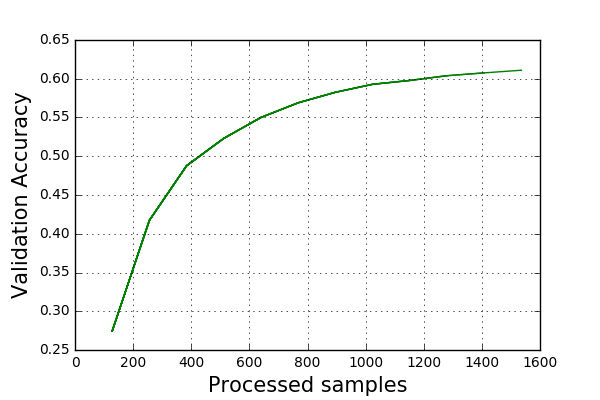

In [ ]:
# setting up running parameters
val_interval = batch_size*2
samples_to_process = 1e5
samples_processed = 0
num_samples_per_epoch = int(num_seq_train/batch_size)
samples_val = []
costs, accs_val = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        #if (num_samples_per_epoch % samples) == 0:
        #    print("shuffling data ...")
        #    X_train, t_train, mask_train, length_train = shuffle_data(
        #        X_train, t_train, mask_train, length_train)
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {X_input: X_train, X_length: length_train,
                        t_input: t_train, t_mask: mask_train}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += batch_size
        #print("samples_processed,", samples_processed)
        #print("batch_cost,", batch_cost)
        #if samples_processed % 1000 == 0: print batch_cost, batch_acc
        #validation data
        if samples_processed % val_interval == 0:
            print("validating")
            fetches_val = [accuracy, y]
            feed_dict_val = {X_input: X_valid, X_length: length_valid, t_input: t_valid,
                             t_mask: mask_valid}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val = res
            samples_val += [samples_processed]
            accs_val += [acc_val]
            #print("validation_accs", acc_val)
            plt.plot(samples_val, accs_val, 'g-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass